### Settings & imports

In [1]:
%matplotlib notebook

In [2]:
import sys
mypath = "/home/basia/Documents/spectroscopy/wassersteinms"
sys.path.insert(0, mypath)
import masserstein 

In [3]:
import os

from masserstein import Spectrum, NMRSpectrum
from masserstein import estimate_proportions

from matplotlib import pyplot as plt

import numpy as np

import pulp

import pickle

import seaborn as sns
from textwrap import wrap

from pathlib import Path

import pandas as pd

import time

In [4]:
nr_of_experiment = 9

### Experiments data

In [5]:
components_dictionary = {'experiment_1': ['Pinene', 'Benzyl benzoate'],
                        'experiment_2': ['Pinene', 'Limonene'],
                        'experiment_7': ['Benzyl benzoate', 'm Anisaldehyde'],
                        'experiment_3': ['Isopropyl myristate', 'Benzyl benzoate', 'Alpha pinene', 'Limonene'],
                        'experiment_6': ['Pinene', 'Benzyl benzoate'],
                        'experiment_5': ['Lactate', 'Alanine', 'Creatine', 'Creatinine', 'Choline chloride'],
                        'experiment_9': ['Lactate', 'Alanine', 'Creatine', 'Creatinine', 'Choline chloride'],
                        'experiment_4': ['Lactate', 'Alanine', 'Creatine', 'Creatinine', 'Choline chloride'],
                        'experiment_8': ['Benzyl benzoate', 'm Anisaldehyde']}

In [6]:
protons_dictionary = {'experiment_1': [16, 12],
                        'experiment_2': [16, 16],
                        'experiment_7': [12, 8],
                        'experiment_3': [34, 12, 16, 16],
                        'experiment_6': [16, 12],
                        'experiment_5': [4, 4, 5, 5, 13],
                        'experiment_9': [4, 4, 5, 5, 13],
                        'experiment_4': [4, 4, 5, 5, 13],
                        'experiment_8': [12, 8]}

In [7]:
ground_truth_molar_proportions = {'experiment_1': [0.09088457406472417, 0.9091154259352758],
                                    'experiment_2': [0.505, 0.495],
                                    'experiment_7': [0.8403875207510383, 0.1596124792489616],
                                    'experiment_3': [0.7264578344443725, 0.10578603326645526, 0.081968804608116, 0.08578732768105625],
                                    'experiment_6': [0.3865, 0.6135],
                                    'experiment_5': [0.3022, 0.2240, 0.1253, 0.2028, 0.1457],
                                    'experiment_9': [0.3022, 0.2240, 0.1253, 0.2028, 0.1457],
                                    'experiment_4': [0.3022, 0.2240, 0.1253, 0.2028, 0.1457],
                                    'experiment_8': [0.3702, 0.6298]}

In [8]:
experiments_folders = {'experiment_1': 'experiment_1_intensity_difference',
                        'experiment_6': 'experiment_6_miniperfumes',
                        'experiment_5': 'experiment_5_metabolites',
                         'experiment_7': 'experiment_7_overlapping_and_intensity_difference',
                         'experiment_9': 'experiment_9_and_4_shim',
                       'experiment_4': 'experiment_9_and_4_shim',
                        'experiment_8': 'experiment_8_different_solvents',
                        'experiment_3': 'experiment_3_perfumes_and_absent_components',
                         'experiment_2': 'experiment_2_overlapping'}

In [9]:
best_kappa_mix = [0.09, 0.05, 0.37, 0.11, 0.03, 0.06, 0.23, 0.2, 0.05]

In [10]:
best_kappa_model = [0.08, 0.01, 0.24, 0.02, 0.09, 0.2, 0.02, 0.29, 0.02]

### Loading the data

In [11]:
if (nr_of_experiment != 9 and nr_of_experiment != 4):
    filename = experiments_folders['experiment_' + str(nr_of_experiment)] + '/preprocessed_mix.csv'
    mix = np.loadtxt(filename, delimiter=',')
else:
    filename = experiments_folders['experiment_' + str(nr_of_experiment)] + '/preprocessed_exp'+str(nr_of_experiment)+'_mix.csv'
    mix = np.loadtxt(filename, delimiter=',')

In [12]:
how_many_components = len(components_dictionary['experiment_'+str(nr_of_experiment)])
names = ['comp' + str(i) for i in range(how_many_components)]

In [13]:
spectra = []
for i in range(how_many_components):
    if (nr_of_experiment != 9 and nr_of_experiment != 4):
        filename = experiments_folders['experiment_' + str(nr_of_experiment)] + \
                    '/preprocessed_comp' + str(i) + '.csv'
        spectra.append(np.loadtxt(filename, delimiter=','))
    else:
        filename = experiments_folders['experiment_' + str(nr_of_experiment)] + \
                    '/preprocessed_exp'+str(nr_of_experiment)+ '_comp'+ str(i) + '.csv'
        spectra.append(np.loadtxt(filename, delimiter=','))

In [14]:
spectra2 = []
names = []
for i in range(len(spectra)):
    spectra2.append(NMRSpectrum(confs=list(zip(spectra[i][:,0], spectra[i][:,1])), 
                                protons=protons_dictionary['experiment_'+str(nr_of_experiment)][i]))
    names.append('comp'+str(i))

spectra = spectra2
del(spectra2)
mix = NMRSpectrum(confs=list(zip(mix[:,0], mix[:,1])))

In [15]:
for i, name in enumerate(names):
    globals()[name] = spectra[i]

In [16]:
# mix.plot(profile=True)
# for sp in spectra:
#     sp.plot(profile=True)

### Estimation with default kappas

In [17]:
default_MTD = 0.25
default_MTD_th = 0.22

In [18]:
start_vis = time.time()
estimation_vis = estimate_proportions(mix, spectra,
                                        MTD=default_MTD, 
                                        MTD_th=default_MTD_th,
                                        verbose=True, solver=pulp.GUROBI(msg=False), 
                                        what_to_compare='area')
stop_vis = time.time()

Set parameter Username
Academic license - for non-commercial use only - expires 2023-11-10


Initial filtering of formulas: 100%|█████████████| 5/5 [00:00<00:00, 144.44it/s]


Removed theoretical spectra due to no matching experimental peaks: []
Envelope bounds: [(0.827366, 4.1272, 0), (0.827366, 4.1272, 1), (0.827366, 4.1272, 2), (0.827366, 4.1272, 3), (0.827366, 4.1272, 4)]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 114598.47it/s]


Number of chunks: 1
ChunkIDs: [0, 0, 0, 0, 0]
Chunk bounds: [(0.577366, 4.3772)]


Splitting the experimental spectrum into chunks: 27129it [00:00, 1518520.19it/s]


Ion currents in chunks: [1.0000000000000013]


Deconvolving chunks:   0%|                                | 0/1 [00:00<?, ?it/s]

Deconvolving chunk 0


/home/basia/.local/lib/python3.10/site-packages/pulp/pulp.py:1352: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:20<00:00, 20.68s/it]

Chunk %i deconvolution status: Optimal
Signal proportion in experimental spectrum: 1.0
Noise proportion in experimental spectrum: 0.0
Total explanation: 1.0
Noise proportion in combination of theoretical spectra: 0.012982665978


In [19]:
estimation_vis['proportions']

[0.2277171004750003,
 0.15221241158600018,
 0.11933757262300015,
 0.17611442219200021,
 0.32461849312400043]

In [20]:
estimation_vis['proportion_of_noise_in_theoretical']

0.012982665978000017

In [21]:
1 - sum(estimation_vis['proportions'])

-1.3322676295501878e-15

In [24]:
print('Estimation took '+ str(stop_vis-start_vis) + ' seconds.')

Estimation took 265.95554876327515 seconds.


In [18]:
start_con = time.time()
estimation_molar = estimate_proportions(mix, spectra,
                                        MTD=default_MTD, 
                                        MTD_th=default_MTD_th,
                                        verbose=True, solver=pulp.GUROBI(msg=False), 
                                        what_to_compare='concentration')
stop_con = time.time()

Set parameter Username
Academic license - for non-commercial use only - expires 2023-11-10


Initial filtering of formulas: 100%|██████████████| 2/2 [00:00<00:00, 64.33it/s]


Removed theoretical spectra due to no matching experimental peaks: []
Envelope bounds: [(-1.97165, 13.9718, 0), (-1.97165, 13.9718, 1)]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]


Number of chunks: 1
ChunkIDs: [0, 0]
Chunk bounds: [(-2.22165, 14.2218)]


Splitting the experimental spectrum into chunks: 131072it [00:00, 3747253.50it/s]


Ion currents in chunks: [1.0000000000000042]


Deconvolving chunks:   0%|                                | 0/1 [00:00<?, ?it/s]

Deconvolving chunk 0


/home/basia/.local/lib/python3.10/site-packages/pulp/pulp.py:1352: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:50<00:00, 170.42s/it]

Chunk %i deconvolution status: Optimal
Signal proportion in experimental spectrum: 0.9898630249
Noise proportion in experimental spectrum: 0.010136975092999989
Total explanation: 0.999999999993
Noise proportion in combination of theoretical spectra: 0.013677671283


In [19]:
estimation_molar

{'proportions': [0.0936759579726857, 0.9063240420273143],
 'Wasserstein distance': 0.020144494451744988}

In [20]:
print('Estimation took '+ str(stop_con-start_con) + ' seconds.')

Estimation took 170.53412175178528 seconds.


In [25]:
# #MTD = 0.25, MTD_th = 0.22

# #1: 'Pinene', 'Benzyl benzoate'
# 0.0937, 0.9063

# #2: 'Pinene', 'Limonene'
# 0.5240, 0.4760

# #3: 'Isopropyl myristate', 'Benzyl benzoate', 'Alpha pinene', 'Limonene'
# 0.7511, 0.1059, 0.0809, 0.0621

# #4: 'Lactate', 'Alanine', 'Creatine', 'Creatinine', 'Choline chloride'
# 0.3165, 0.2137, 0.1341, 0.1960, 0.1397

# #5: 'Lactate', 'Alanine', 'Creatine', 'Creatinine', 'Choline chloride'
# 0.3180, 0.2113, 0.1293, 0.2018, 0.1397

# #6: 'Pinene', 'Benzyl benzoate'
# 0.3931, 0.6069

# #7: 'Benzyl benzoate', 'm Anisaldehyde'
# 0.8428, 0.1572

# #8: 'Benzyl benzoate', 'm Anisaldehyde'
# 0.3762, 0.6238

# #9: Lactate', 'Alanine', 'Creatine', 'Creatinine', 'Choline chloride'
# 0.3180, 0.2125, 0.1333, 0.1967, 0.1395

#### Saving results of estimation with default parameters

In [26]:
res_vis = pd.DataFrame(np.array(estimation_vis['proportions']).reshape(1,-1), 
             columns = components_dictionary['experiment_'+str(nr_of_experiment)])
res_vis

,Lactate,Alanine,Creatine,Creatinine,Choline chloride
0,0.227601,0.151269,0.115668,0.180571,0.324891


In [27]:
res_con = pd.DataFrame(np.array(estimation_molar['proportions']).reshape(1,-1), 
             columns = components_dictionary['experiment_'+str(nr_of_experiment)])
res_con

,Lactate,Alanine,Creatine,Creatinine,Choline chloride
0,0.317956,0.21132,0.129269,0.201804,0.139652


In [28]:
# if (nr_of_experiment != 9 and nr_of_experiment != 4):
#     res_vis.to_csv(experiments_folders['experiment_' + str(nr_of_experiment)]+
#                    '/results_area_default_parameters.csv')
# else:
#     res_vis.to_csv(experiments_folders['experiment_' + str(nr_of_experiment)]+
#                    '/results_area__default_parameters_exp'+str(nr_of_experiment)+'.csv')

In [29]:
# if (nr_of_experiment != 9 and nr_of_experiment != 4):
#     res_con.to_csv(experiments_folders['experiment_' + str(nr_of_experiment)]+
#                '/results_concentration_default_parameters.csv')
# else:
#     res_con.to_csv(experiments_folders['experiment_' + str(nr_of_experiment)]+
#                '/results_concentration_default_parameters_exp'+str(nr_of_experiment)+'.csv')

In [22]:
# comp_noise = np.array(estimation_vis['proportion_of_noise_in_theoretical']).reshape(-1)
# if (nr_of_experiment != 9 and nr_of_experiment != 4):
#     np.savetxt(experiments_folders['experiment_' + \
#                                     str(nr_of_experiment)] + \
#                                     '/proportion_of_noise_in_comp'+ \
#                                     '_default_parameters.csv',
#                                       comp_noise)
# else:
#     np.savetxt(experiments_folders['experiment_' + \
#                                     str(nr_of_experiment)] + \
#                                     '/proportion_of_noise_in_comp'+ \
#                                     '_exp' + str(nr_of_experiment) + \
#                                     '_default_parameters.csv',
#                                       comp_noise)

In [23]:
# mix_noise = np.array(1 - sum(estimation_vis['proportions'])).reshape(-1)
# if (nr_of_experiment != 9 and nr_of_experiment != 4):
#     np.savetxt(experiments_folders['experiment_' + \
#                                     str(nr_of_experiment)] + \
#                                     '/proportion_of_noise_in_mix'+ \
#                                     '_default_parameters.csv',
#                                       mix_noise)
# else:
#     np.savetxt(experiments_folders['experiment_' + \
#                                     str(nr_of_experiment)] + \
#                                     '/proportion_of_noise_in_mix'+ \
#                                     '_exp' + str(nr_of_experiment) + \
#                                     '_default_parameters.csv',
#                                       comp_noise)

### Estimation

In [30]:
start_vis_opt = time.time()
estimation_vis_opt = estimate_proportions(mix, spectra,
                                        MTD=best_kappa_mix[nr_of_experiment-1], 
                                        MTD_th=best_kappa_model[nr_of_experiment-1],
                                        verbose=True, solver=pulp.GUROBI(msg=False), 
                                        what_to_compare='area')
stop_vis_opt = time.time()

Initial filtering of formulas: 100%|█████████████| 5/5 [00:00<00:00, 144.11it/s]


Removed theoretical spectra due to no matching experimental peaks: []
Envelope bounds: [(0.80732, 4.107280000000001, 0), (0.80732, 4.107280000000001, 1), (0.80732, 4.107280000000001, 2), (0.80732, 4.107280000000001, 3), (0.80732, 4.107280000000001, 4)]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 209715.20it/s]


Number of chunks: 1
ChunkIDs: [0, 0, 0, 0, 0]
Chunk bounds: [(0.7173200000000001, 4.197280000000001)]


Splitting the experimental spectrum into chunks: 54259it [00:00, 3259646.51it/s]


Ion currents in chunks: [0.9999999999999941]


Deconvolving chunks:   0%|                                | 0/1 [00:00<?, ?it/s]

Deconvolving chunk 0


/home/basia/.local/lib/python3.10/site-packages/pulp/pulp.py:1352: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:45<00:00, 45.65s/it]

Chunk %i deconvolution status: Optimal
Signal proportion in experimental spectrum: 0.986165643791
Noise proportion in experimental spectrum: 0.013834356208999995
Total explanation: 1.0
Noise proportion in combination of theoretical spectra: 0.015281259506


In [31]:
print('Estimation took '+ str(stop_vis_opt-start_vis_opt) + ' seconds.')

Estimation took 45.731362104415894 seconds.


In [32]:
estimation_vis_opt['proportions']

[0.2147787636609987,
 0.1514447914439991,
 0.11514143271199932,
 0.17965840774699895,
 0.3251422482269981]

In [33]:
estimation_vis_opt['proportion_of_noise_in_theoretical']

0.01528125950599991

In [34]:
start_con_opt = time.time()
estimation_molar_opt = estimate_proportions(mix, spectra,
                                        MTD=best_kappa_mix[nr_of_experiment-1], 
                                        MTD_th=best_kappa_model[nr_of_experiment-1],
                                        verbose=True, solver=pulp.GUROBI(msg=False), 
                                        what_to_compare='concentration')
stop_con_opt = time.time()

Initial filtering of formulas: 100%|█████████████| 5/5 [00:00<00:00, 138.08it/s]


Removed theoretical spectra due to no matching experimental peaks: []
Envelope bounds: [(0.80732, 4.107280000000001, 0), (0.80732, 4.107280000000001, 1), (0.80732, 4.107280000000001, 2), (0.80732, 4.107280000000001, 3), (0.80732, 4.107280000000001, 4)]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 207638.81it/s]


Number of chunks: 1
ChunkIDs: [0, 0, 0, 0, 0]
Chunk bounds: [(0.7173200000000001, 4.197280000000001)]


Splitting the experimental spectrum into chunks: 54259it [00:00, 3130467.70it/s]


Ion currents in chunks: [0.9999999999999941]


Deconvolving chunks:   0%|                                | 0/1 [00:00<?, ?it/s]

Deconvolving chunk 0


Deconvolving chunks: 100%|████████████████████████| 1/1 [00:45<00:00, 45.17s/it]

Chunk %i deconvolution status: Optimal
Signal proportion in experimental spectrum: 0.986165643791
Noise proportion in experimental spectrum: 0.013834356208999995
Total explanation: 1.0
Noise proportion in combination of theoretical spectra: 0.015281259506


In [35]:
print('Estimation took '+ str(stop_con_opt-start_con_opt) + ' seconds.')

Estimation took 45.25510573387146 seconds.


In [36]:
estimation_molar_opt['proportions']

[0.3059059426202505,
 0.21570038346401188,
 0.1311952742739669,
 0.20470766712576569,
 0.14249073251600508]

### Saving estimation results

In [37]:
res_vis_opt = pd.DataFrame(np.array(estimation_vis_opt['proportions']).reshape(1,-1), 
             columns = components_dictionary['experiment_'+str(nr_of_experiment)])
res_vis_opt

,Lactate,Alanine,Creatine,Creatinine,Choline chloride
0,0.214779,0.151445,0.115141,0.179658,0.325142


In [38]:
res_con_opt = pd.DataFrame(np.array(estimation_molar_opt['proportions']).reshape(1,-1), 
             columns = components_dictionary['experiment_'+str(nr_of_experiment)])
res_con_opt

,Lactate,Alanine,Creatine,Creatinine,Choline chloride
0,0.305906,0.2157,0.131195,0.204708,0.142491


In [39]:
# if (nr_of_experiment != 9 and nr_of_experiment != 4):
#     res_vis_opt.to_csv(experiments_folders['experiment_' + str(nr_of_experiment)]+
#                    '/results_area.csv')
# else:
#     res_vis_opt.to_csv(experiments_folders['experiment_' + str(nr_of_experiment)]+
#                    '/results_area_exp'+str(nr_of_experiment)+'.csv')

In [40]:
# if (nr_of_experiment != 9 and nr_of_experiment != 4):
#     res_con_opt.to_csv(experiments_folders['experiment_' + str(nr_of_experiment)]+
#                '/results_concentration.csv')
# else:
#     res_con_opt.to_csv(experiments_folders['experiment_' + str(nr_of_experiment)]+
#                '/results_concentration_exp'+str(nr_of_experiment)+'.csv')

### Mixture vs linear combination of components (noise removed)

In [41]:
ignore_negative = False

In [42]:
def make_nonnegative(ints):
    res_ints = ints
    for col_nr in range(ints.shape[1]):
        neg = ints[:,col_nr]<0
        res_ints[:,col_nr][neg]=0
    return(res_ints)

#### Mix

In [43]:
ppm = np.array(mix.confs)[:,0]
mix_ints = np.array(mix.confs)[:,1]

In [44]:
mix_without_noise = NMRSpectrum(confs = list(zip(ppm, mix_ints - np.array(estimation_vis['noise']))))
mix_without_noise = np.array(mix_without_noise.confs)[:,1]

In [45]:
if ignore_negative:
    mix_without_noise = make_nonnegative(mix_without_noise.reshape(-1,1))

In [46]:
mix_without_noise = mix_without_noise/sum(mix_without_noise)

In [47]:
thr = -1e-4
print('Is there a lot of negative signal in mixture (intensity below '+str(thr)+')?')
print(sum(mix_without_noise[mix_without_noise<thr]))

Is there a lot of negative signal in mixture (intensity below -0.0001)?
0


#### Components

In [48]:
components_ints = []
for spectrum in spectra:
    components_ints.append(np.array(spectrum.confs)[:,1])#.reshape(-1,1))

In [49]:
thr = -1e-4
for i, arr in enumerate(components_ints):
    print('Is there a lot of negative signal in mixture (intensity below '+str(thr)+')?')
    print('Component '+str(i)+':')
    print(sum(arr[arr<thr]))

Is there a lot of negative signal in mixture (intensity below -0.0001)?
Component 0:
0
Is there a lot of negative signal in mixture (intensity below -0.0001)?
Component 1:
0
Is there a lot of negative signal in mixture (intensity below -0.0001)?
Component 2:
0
Is there a lot of negative signal in mixture (intensity below -0.0001)?
Component 3:
0
Is there a lot of negative signal in mixture (intensity below -0.0001)?
Component 4:
0


In [50]:
p = estimation_vis['proportions']
p = np.array(p).reshape(len(p),1)

In [51]:
names_components_up_to = ['sum_up_to_'+str(i+1) for i in range(len(spectra))]

In [52]:
components = [comp.reshape(-1,1) for comp in components_ints]
components_no_scaling = np.concatenate(components, axis=1)
components_scaled = components_no_scaling*p[:,0]

In [53]:
proportions_point_by_point = (components_scaled/np.sum(components_scaled, axis=1).reshape(-1,1))
proportions_point_by_point = np.nan_to_num(proportions_point_by_point)
noise_in_ref = np.array(estimation_vis['noise_in_theoretical']).reshape(-1,1)
noise_split_for_components = proportions_point_by_point*noise_in_ref

/tmp/ipykernel_21646/2062537961.py:1: RuntimeWarning: invalid value encountered in divide
  proportions_point_by_point = (components_scaled/np.sum(components_scaled, axis=1).reshape(-1,1))


In [54]:
(np.round(components_scaled-noise_split_for_components, decimals=5)>=0).all()

True

In [55]:
X = components_scaled - noise_split_for_components

In [56]:
(np.sum(X[:,:1], axis=1)==X[:,0]).all()

True

In [57]:
if ignore_negative:
    X = make_nonnegative(X)

In [58]:
for i, name in enumerate(names_components_up_to):
    #not_normalized = np.sum(X[:,:(i+1)], axis=1)
    
    globals()[name] = np.sum(X[:,:(i+1)], axis=1)

In [59]:
xlims_lower = [1.55, 1.6, 4.4, 3.55, 3.55, 1.55, 7.3, 9.1, 3.55]
xlims_upper = [2.45, 2.4, 7.8, 4.05, 4.05, 2.4, 7.6, 10.1, 4.05]
ylims_lower = [-0.00005, -0.00005, -0.000025, -0.00005, -0.00005, -0.00005, -0.00005, -0.00005, -0.00005]
ylims_upper = [0.00045, 0.0025, 0.00016, 0.0016, 0.0011, 0.0016, 0.0026, 0.0014, 0.0016]

<IPython.core.display.Javascript object>


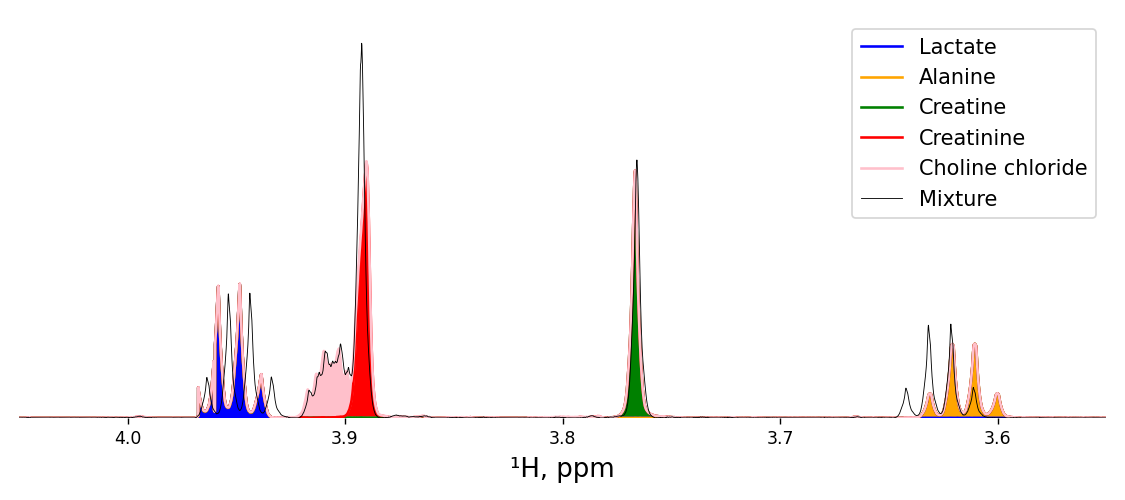

In [60]:
colors = ['blue', 'orange', 'green', 'red', 'pink']
fig, ax = plt.subplots()
fig.set_size_inches(9, 4, forward=True)

ax.set_xlim(xlims_lower[nr_of_experiment-1], xlims_upper[nr_of_experiment-1])
ax.set_ylim(None, ylims_upper[nr_of_experiment-1])
ax.get_yaxis().set_visible(False)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)


plt.xlabel(chr(0x00b9)+'H, ppm', fontsize=15, labelpad=5)
#plt.ylabel('Relative intensity', fontsize=15, labelpad=10)

for i, name in enumerate(names_components_up_to):
    ax.plot(ppm, globals()[name], alpha=1.0, color = colors[i], 
            label=components_dictionary['experiment_'+str(nr_of_experiment)][i])
    if i==0:
        ax.fill_between(ppm, 0, globals()[name], color=colors[0], alpha=1.0)
    else:
        predecessor = name[:-1]+str(i)
        ax.fill_between(ppm, globals()[predecessor] , globals()[name], color=colors[i], alpha=1.0)
ax.plot(ppm, mix_without_noise, color='black', alpha=1.0, label='Mixture', linewidth=0.5)
ax.legend(prop={'size': 12}, loc='upper right')
ax.invert_xaxis()
plt.tight_layout()
#plt.savefig(os.getcwd()+'/spectra_visualisation/experiment'+str(nr_of_experiment)+'.jpg', dpi=300)

In [61]:
estimation_vis['proportion_of_noise_in_theoretical']

0.013973605410999918

In [62]:
1-sum(estimation_vis['proportions'])

-9.940936962493652e-13